In [32]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from glob import glob
from PIL import Image
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import to_categorical, plot_model
from keras.layers import Input
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [33]:
skinDf=pd.read_csv('/kaggle/input/HAM10000_metadata.csv')
skinDf.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [34]:
labelEncoder = LabelEncoder()
labelEncoder.fit(skinDf['dx'])
skinDf['label']=labelEncoder.transform(skinDf['dx'])

dfs_by_label_resampled = {}
n_samples = 800

for label in range(7):  
    df_label_resampled = resample(skinDf[skinDf['label'] == label], n_samples=n_samples, replace=True, random_state=42)
    
    # Append the resampled DataFrame to the dictionary
    dfs_by_label_resampled[label] = df_label_resampled

balanced_df = pd.concat(dfs_by_label_resampled.values())

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['label'].value_counts()

imgPath={os.path.splitext(os.path.basename(x))[0]: x
                            for x in glob(os.path.join('/kaggle/input/','*','*.jpg'))}    

size = (76, 76)

balanced_df['image'] = balanced_df['image_id'].map(imgPath.get).map(lambda x: np.asarray(Image.open(x).resize(size)))

In [35]:
x=np.asarray(balanced_df['image'].to_list())

y=balanced_df['label']
y=to_categorical(y, num_classes=7)

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True)  # 0.25 x 0.8 = 0.2

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

x_train shape: (3360, 76, 76, 3) - y_train shape: (3360, 7)
x_test shape: (1120, 76, 76, 3) - y_test shape: (1120, 7)
x_val shape: (1120, 76, 76, 3) - y_val shape: (1120, 7)


In [36]:
train_y = y_train
test_y = y_test
val_y = y_val
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
y_val = np.argmax(y_val, axis=1)

# Ensure data type is float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

# Normalize the pixel values to the range [0, 1]
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0

# resize images to 96x96
x_train = np.array([resize(image, (96, 96)) for image in x_train])
x_test = np.array([resize(image, (96, 96)) for image in x_test])
x_val = np.array([resize(image, (96, 96)) for image in x_val])

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

x_train shape: (3360, 96, 96, 3) - y_train shape: (3360,)
x_test shape: (1120, 96, 96, 3) - y_test shape: (1120,)
x_val shape: (1120, 96, 96, 3) - y_val shape: (1120,)


In [37]:
num_classes=7
batch_size = 32
classes = ['aklec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
input_shape = (96, 96, 3)
input_layer = Input(shape=input_shape)

In [38]:
def plot_images(df, indices, width=200, height=200):
    num_images = len(indices)
    size = (128, 128)
    images = [Image.fromarray(df['image'].iloc[i]).resize(size) for i in indices]
    images = [np.array(img) for img in images]

    fig = make_subplots(rows=1, cols=num_images, subplot_titles=[f"{classes[df['label'].iloc[i]]}" for i in indices])

    for i, img in enumerate(images, start=1):
        fig.add_trace(go.Image(z=img), row=1, col=i)

    fig.update_layout(
        width=width*num_images,  # Adjust the total width of the plot
        height=height,
        margin=dict(l=10, r=10, t=45, b=20),
    )

    fig.show()

In [39]:
plot_images(balanced_df, [1, 2, 3, 8])
plot_images(balanced_df, [9, 17, 29])

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images by 20 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by 10%
    height_shift_range=0.1,  # randomly shift images vertically by 10%
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not flip images vertically
    zoom_range=0.1  # randomly zoom into images by 20%
)

# Fit the data generator on the training data
datagen.fit(x_train)

# Generate augmented data
augmented_data = datagen.flow(x_train, y_train, batch_size=batch_size)

### Xception Model

In [41]:
from keras.applications.xception import Xception

xception_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in xception_model.layers:
    layer.trainable = True

x = xception_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_xception_model = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_xception = Model(inputs=input_layer, outputs=output_xception_model)

In [42]:
# Compile the model
model_xception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Train the model
history_xception = model_xception.fit(
    augmented_data,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/30
  1/105 ━━━━━━━━━━━━━━━━━━━━ 1:05:18 38s/step - accuracy: 0.0938 - loss: 2.0009

W0000 00:00:1715697003.262600     167 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4400 - loss: 1.5048

W0000 00:00:1715697015.946958     168 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.4411 - loss: 1.5024 - val_accuracy: 0.3438 - val_loss: 5.6907 - learning_rate: 0.0010
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.7170 - loss: 0.8281 - val_accuracy: 0.5929 - val_loss: 1.3248 - learning_rate: 0.0010
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.7700 - loss: 0.6559 - val_accuracy: 0.6973 - val_loss: 1.0219 - learning_rate: 0.0010
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.8165 - loss: 0.5175 - val_accuracy: 0.6527 - val_loss: 1.2834 - learning_rate: 0.0010
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.8253 - loss: 0.4771 - val_accuracy: 0.7563 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.8658 - loss: 0.3892 - val_accuracy: 0.7321 - val_loss: 0.9148 - learning_rate: 0.0010
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.8784 - loss:

### InceptionResNetV2 Model

In [43]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

inception_resnet_v2_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in inception_resnet_v2_model.layers:
    layer.trainable = True

x = inception_resnet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_inception_resnet_v2 = tf.keras.layers.Dense(7, activation='softmax')(x)

model_inception_resnet_v2 = Model(inputs=input_layer, outputs=output_inception_resnet_v2)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [44]:
# Compile the model
model_inception_resnet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Train the model
history_inception_resnet_v2 = model_inception_resnet_v2.fit(
    augmented_data,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/30
  1/105 ━━━━━━━━━━━━━━━━━━━━ 5:09:11 178s/step - accuracy: 0.0625 - loss: 2.1571

W0000 00:00:1715697533.843135     168 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4490 - loss: 1.6917

W0000 00:00:1715697558.219851     166 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 205s 252ms/step - accuracy: 0.4500 - loss: 1.6884 - val_accuracy: 0.2964 - val_loss: 2.5986 - learning_rate: 0.0010
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.7051 - loss: 0.9212 - val_accuracy: 0.5473 - val_loss: 1.2203 - learning_rate: 0.0010
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.7294 - loss: 0.8386 - val_accuracy: 0.6170 - val_loss: 1.1318 - learning_rate: 0.0010
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7155 - loss: 0.9243 - val_accuracy: 0.4446 - val_loss: 3356.4504 - learning_rate: 0.0010
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7330 - loss: 0.7553 - val_accuracy: 0.7223 - val_loss: 1.0430 - learning_rate: 0.0010
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7945 - loss: 0.6241 - val_accuracy: 0.7125 - val_loss: 0.7774 - learning_rate: 0.0010
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.7202 - l

### MobileNetV2 Model

In [45]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in mobilenet_v2_model.layers:
    layer.trainable = True

x = mobilenet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output_mobilenet_v2_model = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_mobilenet_v2 = Model(inputs=input_layer, outputs=output_mobilenet_v2_model)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
# Compile the model
model_mobilenet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Train the model
history_mobilenet_v2 = model_mobilenet_v2.fit(
    augmented_data,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
  3/105 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9219 - loss: 0.2113    

W0000 00:00:1715698350.175435     168 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8121 - loss: 0.6098

W0000 00:00:1715698360.837984     167 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 107ms/step - accuracy: 0.8118 - loss: 0.6102 - val_accuracy: 0.4366 - val_loss: 4.3961 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8039 - loss: 0.6209 - val_accuracy: 0.2188 - val_loss: 10.4837 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.8035 - loss: 0.6104 - val_accuracy: 0.3143 - val_loss: 8.7031 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8364 - loss: 0.5032 - val_accuracy: 0.1446 - val_loss: 34.6870 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8054 - loss: 0.6678 - val_accuracy: 0.4045 - val_loss: 7.0231 - learning_rate: 0.0010
Epoch 6/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8222 - loss: 0.5520
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8221 - loss: 0.5521 - 

### GradCAM Analysis

In [49]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str

    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
        # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    
    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

### View all Convolution Layers of all 3 models

In [115]:
xception_conv2D_layers = [layer.name for layer in reversed(xception_model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]
inception_resnet_v2_conv2D_layers = [layer.name for layer in reversed(inception_resnet_v2_model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]
mobilenet_v2_conv2D_layers = [layer.name for layer in reversed(mobilenet_v2_model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]
# print(inception_resnet_v2_conv2D_layers)
# print(xception_conv2D_layers)
# print(mobilenet_v2_conv2D_layers)

In [51]:
# Function to visualize grad-cam for multiple indices of test dataset
def visualize_grad_cam_for_indices(model, images, labels, indices, layer_name):
    """
    Generate and visualize Grad-CAM heatmaps for multiple images and a specified layer.

    Args:
        model: Keras model.
        images: List or array of image data.
        labels: List or array of ground truth labels corresponding to the images.
        indices: Array of indices of the images to visualize.
        layer_name: Name of the layer for which Grad-CAM heatmaps will be generated.
    """
    plt.figure(figsize=(4 * len(indices), 4))

    for i, index in enumerate(indices):
        img = images[index]
        label = labels[index]

        grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer_name)
        grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)

        ax = plt.subplot(1, len(indices), i + 1)
        plt.imshow(grad_cam_superimposed)
        plt.axis('off')
        plt.title(f'{classes[label]} ({layer_name})', fontsize=16)

    plt.tight_layout()
    plt.show()

    
# Function to display original images for multiple indices of test dataset
def show_images_by_indices(images, labels, indices):
    """
    Display images from an array of images based on specified indices.

    Args:
        images: List or array of image data.
        indices: Array of indices of the images to display.
    """
    num_images = len(indices)
    plt.figure(figsize=(4*len(indices), 4))
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(classes[labels[idx]], fontsize=16)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### Grad-CAM Visualization of Xception Model

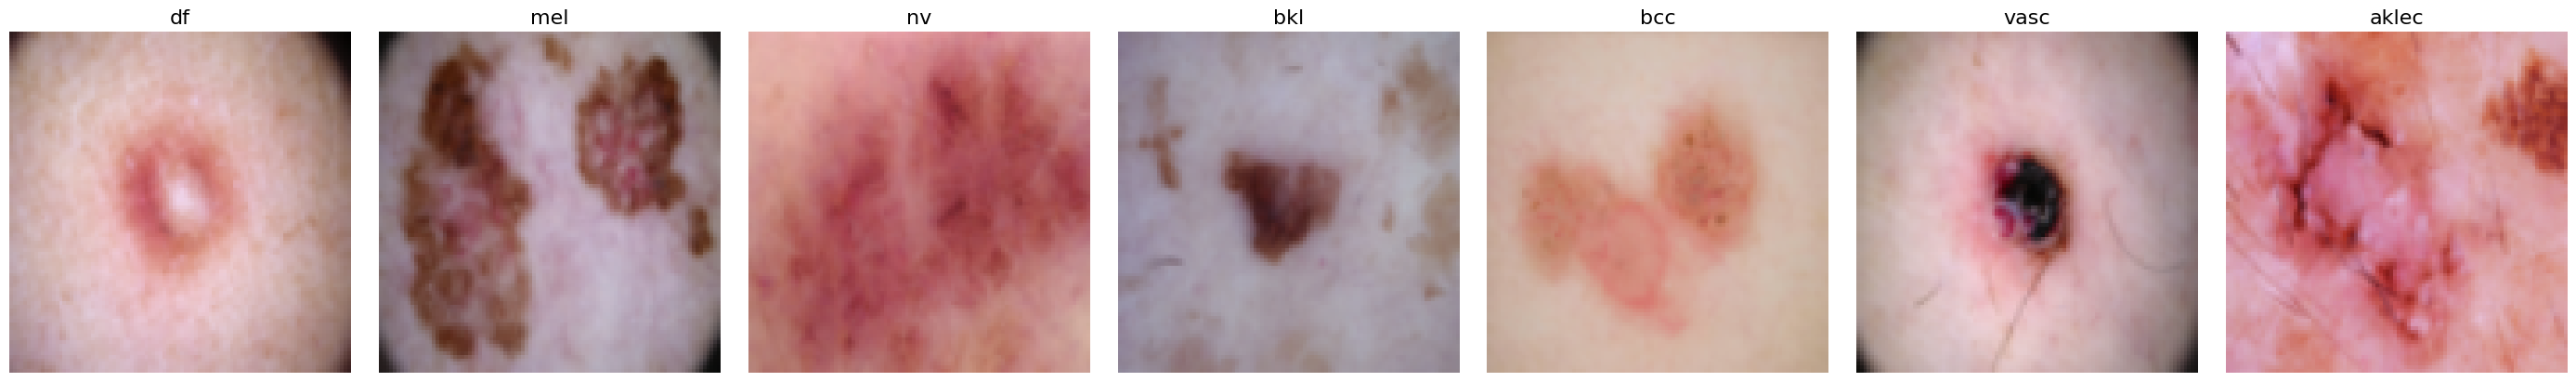

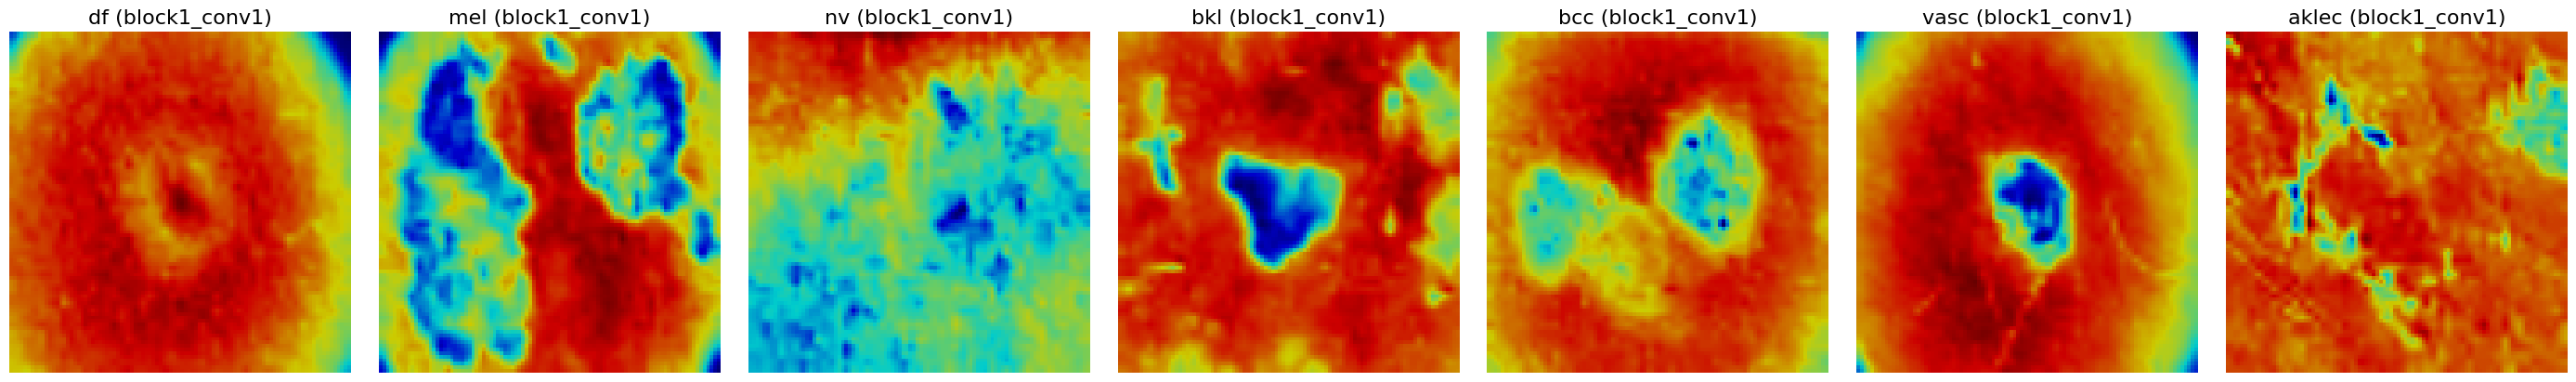

In [107]:
show_images_by_indices(x_test, y_test, [13,0,6,3,4,5,2])
visualize_grad_cam_for_indices(xception_model, x_test, y_test, [13,0,6,3,4,5,2], 'block1_conv1')

### Grad-CAM Visualization of InceptionResNetV2 Model

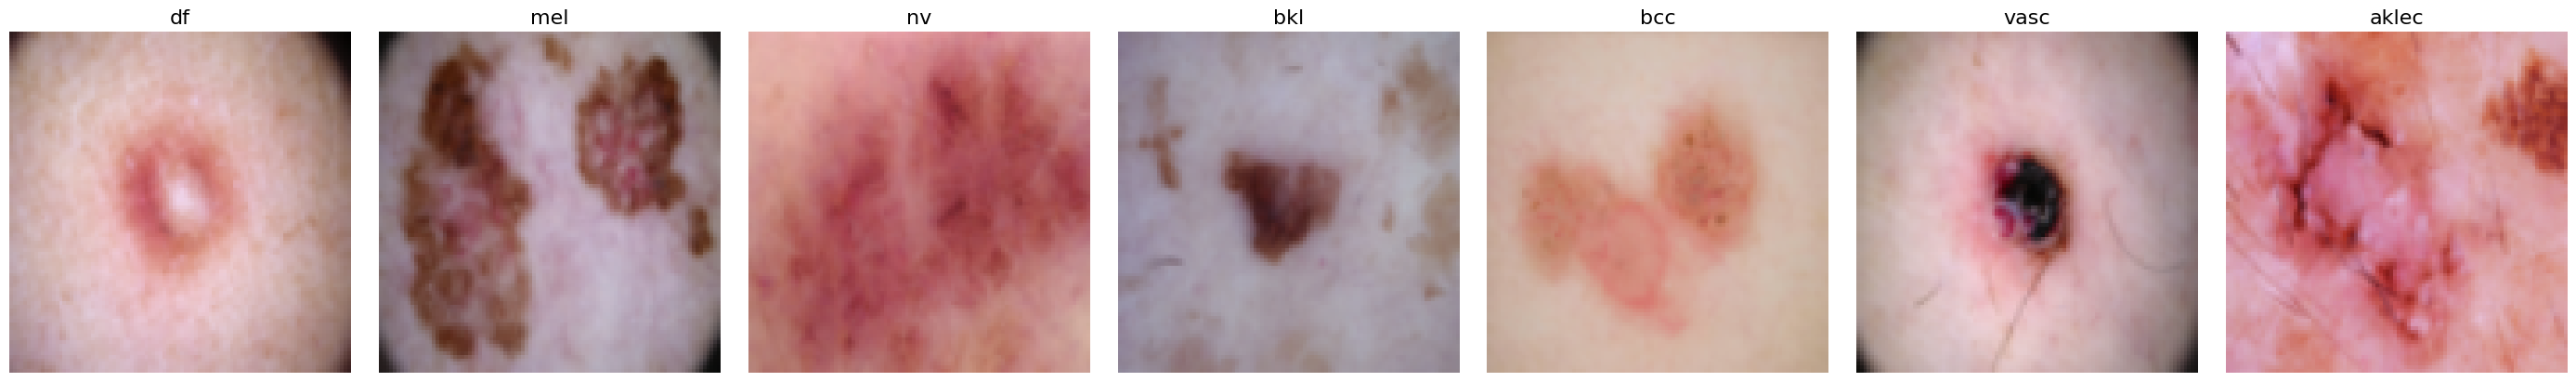

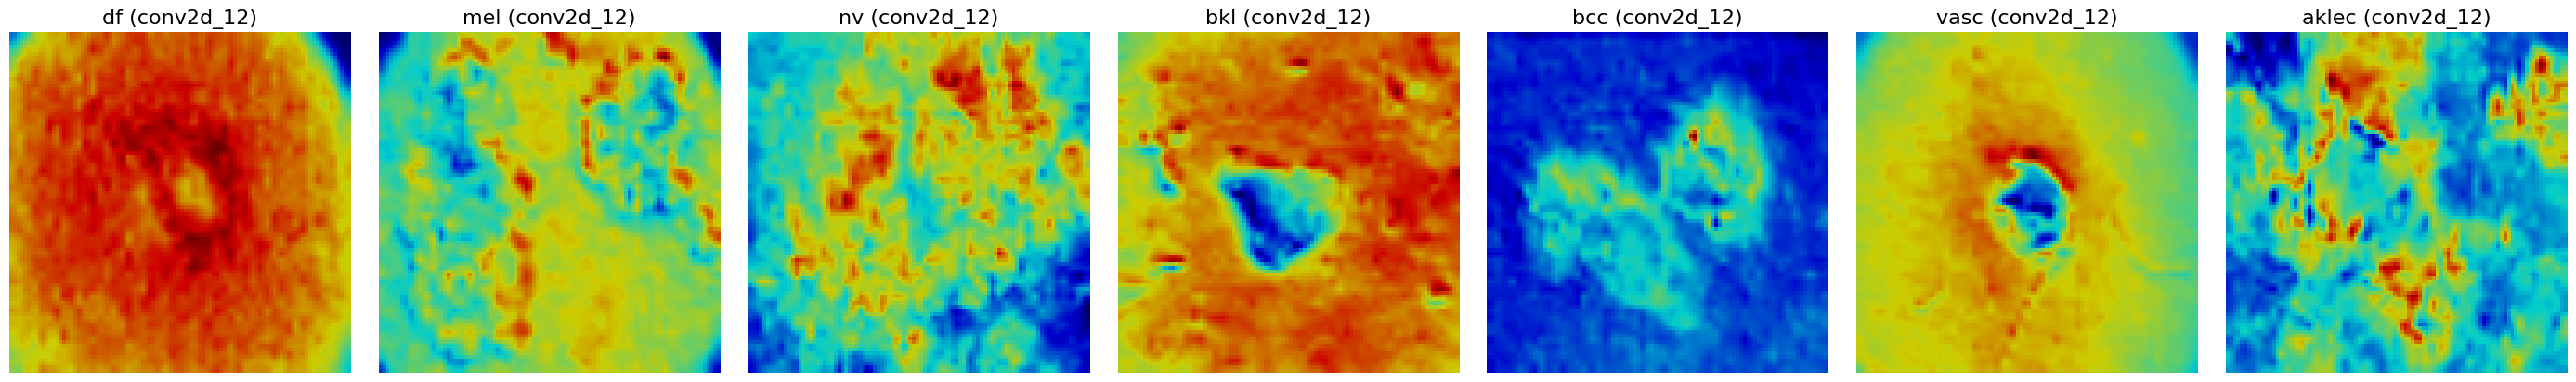

In [109]:
show_images_by_indices(x_test, y_test, [13,0,6,3,4,5,2])
visualize_grad_cam_for_indices(inception_resnet_v2_model, x_test, y_test, [13,0,6,3,4,5,2], 'conv2d_12')

### Grad-CAM Visualization of MobileNetV2 Model

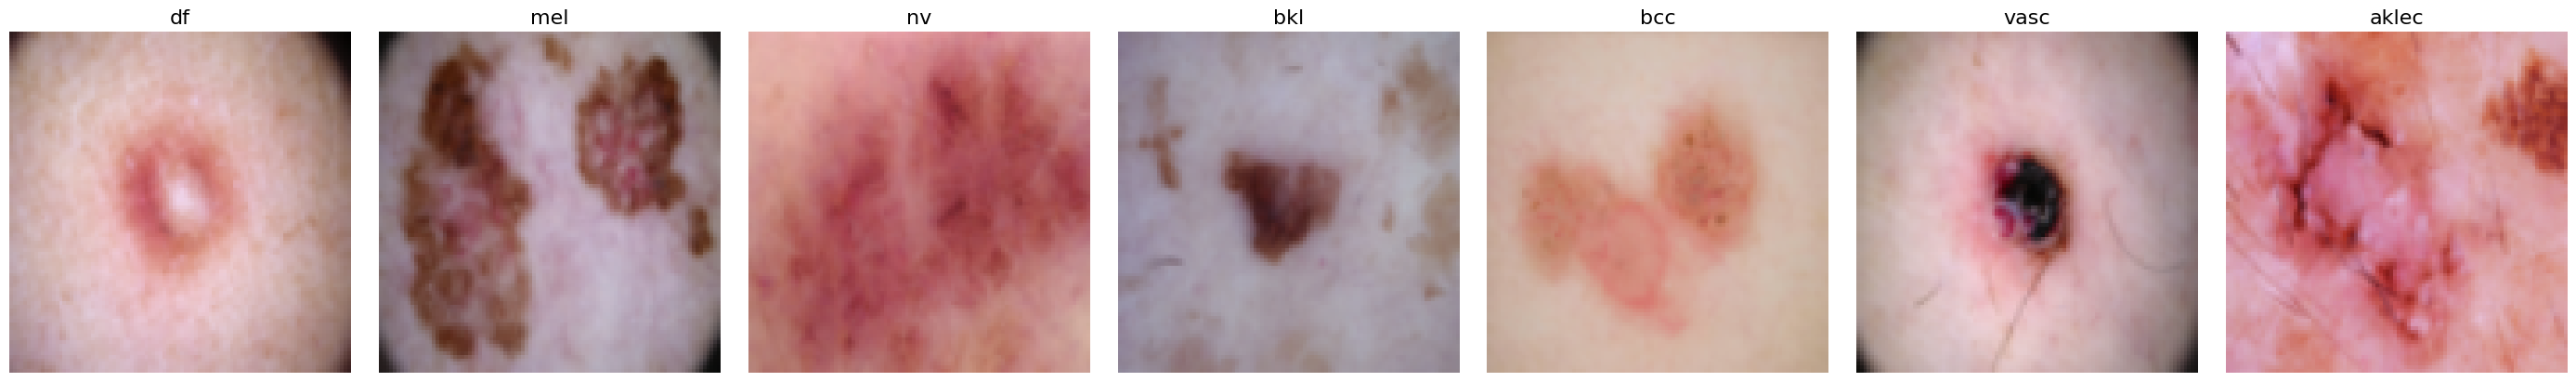

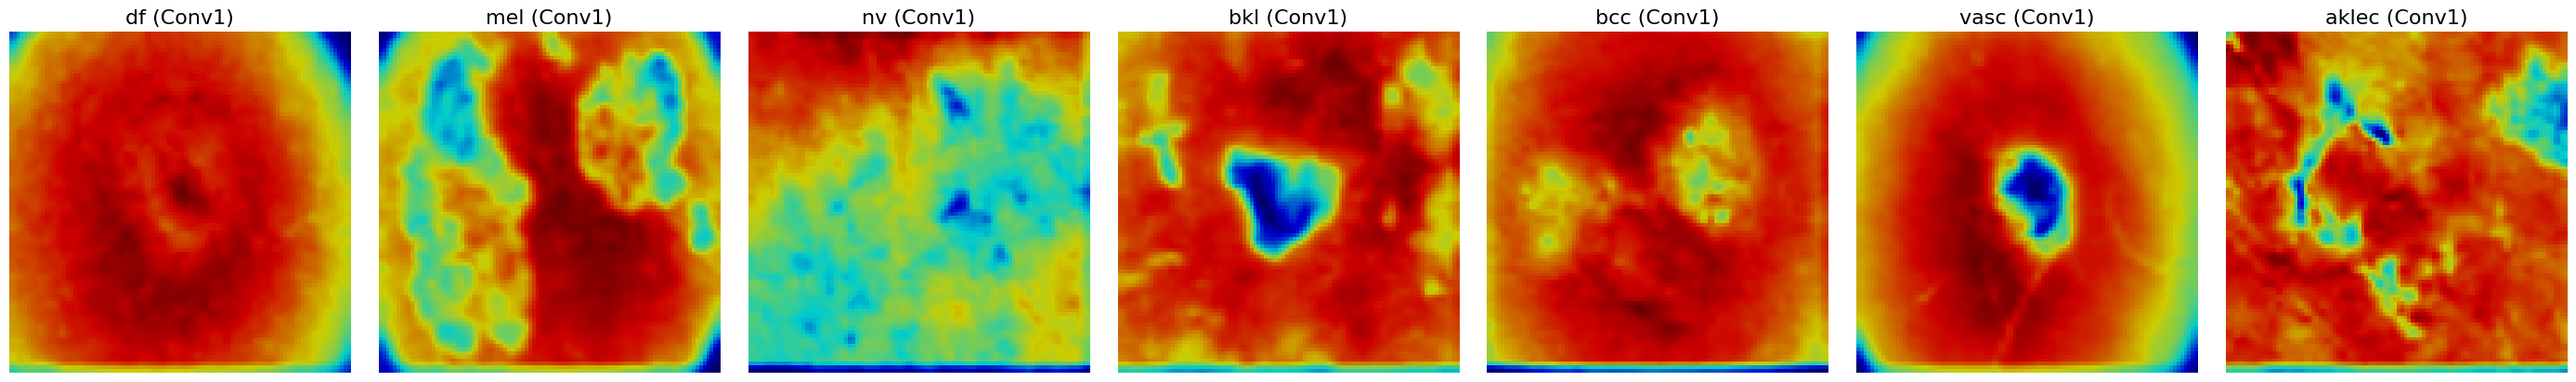

In [104]:
show_images_by_indices(x_test, y_test, [13,0,6,3,4,5,2])
visualize_grad_cam_for_indices(mobilenet_v2_model, x_test, y_test, [13,0,6,3,4,5,2], 'Conv1')